In [1]:
import matplotlib.pyplot as plt 
import json
import pickle
import torch
import random 
import numpy as np
import os 

from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import binary_cross_entropy
from sklearn import metrics 

from data_loaders.assist2009 import ASSIST2009
from data_loaders.assist2012 import ASSIST2012
from data_loaders.ednet01 import EdNet01

from models.dkt import DKT
from models.dkt import dkt_train
from torch.nn.functional import one_hot, binary_cross_entropy

from models.utils import collate_fn, collate_ednet, cal_acc_class

%matplotlib inline

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

c:\Users\user2\Desktop\master_degree\research\env_research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = 'dkt'
dataset_name = 'ASSIST2009'
dataset = None
ckpts = f"ckpts/{model_name}/{dataset_name}/"

with open("config.json") as f:
    config = json.load(f)
    model_config = config[model_name]
    train_config = config["train_config"]
    
batch_size = train_config["batch_size"]
num_epochs = train_config["num_epochs"]
train_ratio = train_config["train_ratio"]
learning_rate = train_config["learning_rate"]
optimizer = train_config["optimizer"] # can be sgd, adam
seq_len = train_config["seq_len"] # 샘플링 할 갯수

In [3]:
# 데이터셋 추가 가능
collate_pt = collate_fn
if dataset_name == "ASSIST2009":
    dataset = ASSIST2009(seq_len, 'datasets/ASSIST2009/')
elif dataset_name == "ASSIST2012":
    dataset = ASSIST2012(seq_len, 'datasets/ASSIST2012/')

In [4]:
def train_model(model, test_loader, ckpt_path):
    '''
        Args:
            train_loader: the PyTorch DataLoader instance for training
            test_loader: the PyTorch DataLoader instance for test
            num_epochs: the number of epochs
            opt: the optimization to train this model
            ckpt_path: the path to save this model's parameters
    '''
    aucs = []
    loss_means = []  
    accs = []
    q_accs = {}
    
    max_auc = 0
    
    # Test
    model.load_state_dict(torch.load(os.path.join(ckpt_path, "model.ckpt"), map_location=device))
    loss_mean = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            q, r, qshft_seqs, rshft_seqs, m, bert_s, bert_t, bert_m, q2diff_seqs, pid_seqs, pidshift, hint_seqs = data

            model.eval()

            original_y = model(q.long(), r.long(), bert_s, bert_t, bert_m)
            y = (original_y * one_hot(qshft_seqs.long(), dataset.num_q)).sum(-1)

            # y와 t 변수에 있는 행렬들에서 마스킹이 true로 된 값들만 불러옴
            q = torch.masked_select(q, m).detach().cpu()
            y = torch.masked_select(y, m).detach().cpu()
            t = torch.masked_select(rshft_seqs, m).detach().cpu()
            
            print(f"qshft: {qshft_seqs.shape}")
            print(f"ori_y: {(original_y * one_hot(qshft_seqs.long(), dataset.num_q)).shape}")

            auc = metrics.roc_auc_score(
                y_true=t.numpy(), y_score=y.numpy()
            )
            bin_y = [1 if p >= 0.5 else 0 for p in y.numpy()]
            acc = metrics.accuracy_score(t.numpy(), bin_y)
            loss = binary_cross_entropy(y, t) 

            print(f"[Test] number: {i}, AUC: {auc}, ACC: :{acc} Loss: {loss} ")

            # evaluation metrics
            aucs.append(auc)
            loss_mean.append(loss)     
            accs.append(acc)
            q_accs, cnt = cal_acc_class(q.long(), t.long(), bin_y)
            break
        loss_means.append(np.mean(loss_mean))


    return aucs, loss_means, accs, q_accs, cnt, qshft_seqs, original_y

In [5]:
print(dataset.num_q)
model = torch.nn.DataParallel(DKT(dataset.num_q, **model_config)).to(device)
train_model = train_model

103


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# 데이터셋 분할
data_size = len(dataset)
train_size = int(data_size * train_ratio) 
valid_size = int(data_size * ((1.0 - train_ratio) / 2.0))
test_size = data_size - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [train_size, valid_size, test_size], generator=torch.Generator(device=device)
)

# pickle에 얼마만큼 분할했는지 읽기
if os.path.exists(os.path.join(dataset.dataset_dir, "train_indices.pkl")):
    with open(
        os.path.join(dataset.dataset_dir, "train_indices.pkl"), "rb"
    ) as f:
        train_dataset.indices = pickle.load(f)
    with open(
        os.path.join(dataset.dataset_dir, "valid_indicies.pkl"), "rb"
    ) as f:
        valid_dataset.indices = pickle.load(f)
    with open(
        os.path.join(dataset.dataset_dir, "test_indices.pkl"), "rb"
    ) as f:
        test_dataset.indices = pickle.load(f)

In [7]:
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=collate_pt, generator=torch.Generator(device=device)
)
valid_loader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=collate_pt, generator=torch.Generator(device=device)
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=collate_pt, generator=torch.Generator(device=device)
)

if optimizer == "sgd":
    opt = SGD(model.parameters(), learning_rate, momentum=0.9)
elif optimizer == "adam":
    opt = Adam(model.parameters(), learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.5)
opt.lr_scheduler = lr_scheduler

# 모델에서 미리 정의한 함수로 AUCS와 LOSS 계산    
aucs, loss_means, accs, q_accs, q_cnts, q, t = \
    train_model(
        model, test_loader, ckpts
    )

qshft: torch.Size([24, 50])
ori_y: torch.Size([24, 50, 103])
[Test] number: 0, AUC: 0.781401050788091, ACC: :0.7613065326633166 Loss: 0.5250938534736633 


In [8]:
import seaborn as sns # 히트맵 사용
import pandas as pd
import matplotlib.pyplot as plt

print(q.shape, t.shape)
q = q.type(torch.uint8)
print(t)

torch.Size([24, 50]) torch.Size([24, 50, 103])
tensor([[[0.4792, 0.5567, 0.4793,  ..., 0.4656, 0.4902, 0.5036],
         [0.4730, 0.5982, 0.4466,  ..., 0.4502, 0.4746, 0.5052],
         [0.4780, 0.6309, 0.4108,  ..., 0.4412, 0.4629, 0.5123],
         ...,
         [0.5638, 0.6077, 0.3665,  ..., 0.4616, 0.5108, 0.6710],
         [0.5608, 0.6083, 0.3849,  ..., 0.4727, 0.5033, 0.7219],
         [0.5718, 0.6153, 0.3995,  ..., 0.4768, 0.4855, 0.7584]],

        [[0.4091, 0.4330, 0.4653,  ..., 0.4573, 0.5040, 0.5776],
         [0.6219, 0.5096, 0.5118,  ..., 0.5095, 0.5007, 0.6995],
         [0.6918, 0.5239, 0.5399,  ..., 0.5243, 0.5168, 0.7420],
         ...,
         [0.4477, 0.1705, 0.4935,  ..., 0.4042, 0.4553, 0.5258],
         [0.4477, 0.1705, 0.4935,  ..., 0.4042, 0.4553, 0.5258],
         [0.4477, 0.1705, 0.4935,  ..., 0.4043, 0.4553, 0.5258]],

        [[0.5052, 0.6054, 0.5529,  ..., 0.4749, 0.5140, 0.4978],
         [0.5079, 0.6728, 0.5993,  ..., 0.4756, 0.5090, 0.4956],
         [0

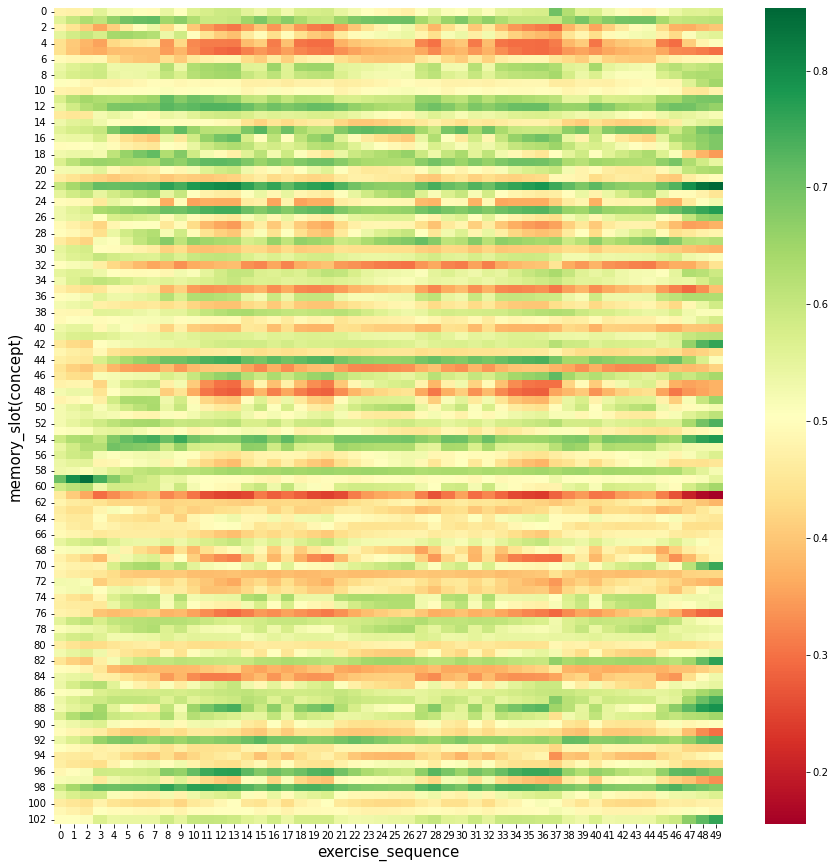

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax = sns.heatmap(t[0].detach().cpu().numpy().T, cmap=plt.get_cmap('RdYlGn'))
# ax.invert_yaxis()
plt.ylabel('memory_slot(concept)', fontsize=15)
plt.xlabel('exercise_sequence', fontsize=15)
plt.show()